<a href="https://www.kaggle.com/code/atieameri/decoding-ad-impact-a-b-test-analysis-of-marketing?scriptVersionId=215079590" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Decoding Ad Impact: A/B Test Analysis of Marketing Campaigns

Decoding Ad Impact: A/B Test Analysis of Marketing Campaigns
add Codeadd Markdown
This project is about analyzing the effectiveness of marketing campaigns using A/B testing, a method where different versions of a variable (in this case, an advertisement) are presented to audiences to evaluate their impact. The focus is on measuring the conversion rate to assess the ad's effectiveness and provide actionable insights for optimizing marketing strategies.

Objectives
To determine if the differences in outcomes between the experimental group (exposed to ads) and the control group (exposed to PSAs or no content) are statistically significant.


# Loading the libiraries

In [1]:
import pandas as pd
import numpy as np

import math
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest, proportion_confint


pd.set_option("display.max_column", 100)
import warnings
warnings.filterwarnings('ignore')

# Loading the dataset

In [2]:
df = pd.read_csv('/kaggle/input/marketing-ab-testing/marketing_AB.csv')
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [3]:
print("The dimension of dataset:",df.shape)

The dimension of dataset: (588101, 7)


In [4]:
### basic understanding
print("Columns: ")
df.columns

Columns: 


Index(['Unnamed: 0', 'user id', 'test group', 'converted', 'total ads',
       'most ads day', 'most ads hour'],
      dtype='object')

# Exploratory Data Analysis

In [5]:
## check if there are any duplicate in user id
df["user id"].duplicated().sum()

0

There is no duplicate. The columns 'Unnamed: 0'and 'user id' are not giving us any information so we remove them. 

In [6]:
## remove 'Unnamed: 0', 'user id' columns
df = df [['test group', 'converted', 'total ads',
       'most ads day', 'most ads hour']]

## Multicolinearity
Check to see if there is any corrolation between numerical columns

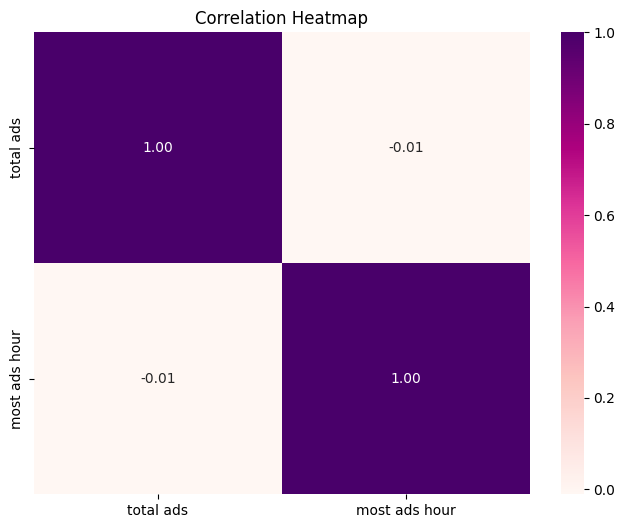

In [7]:
df_num = df.select_dtypes(include=['number'])
correlation_matrix = df_num.corr()
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='RdPu', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

There is no corrolation among numerical values. 

## Missing Values

In [8]:
# Get missing values count for all columns
missing_values = df.isnull().sum()
missing_values

test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64

There is no missing values. 

## Outliers

In [9]:
df.describe()

,total ads,most ads hour
count,588101.000000,588101.000000
mean,24.820876,14.469061
std,43.715181,4.834634
min,1.000000,0.000000
25%,4.000000,11.000000
50%,13.000000,14.000000
75%,27.000000,18.000000
max,2065.000000,23.000000


We that that maximum for total ads is an usual number. So we remove the outliers. 

In [10]:
# Calculate Q1, Q3, and IQR
Q1 = df['total ads'].quantile(0.25)
Q3 = df['total ads'].quantile(0.75)
IQR = Q3 - Q1

# Determine bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


# Remove outliers
df_no_outliers = df[(df['total ads'] >= lower_bound) & (df['total ads'] <= upper_bound)]

print("Original DataFrame:")
df_no_outliers.describe()


Original DataFrame:


,total ads,most ads hour
count,536044.000000,536044.000000
mean,15.134015,14.475189
std,14.063618,4.834794
min,1.000000,0.000000
25%,4.000000,11.000000
50%,11.000000,14.000000
75%,22.000000,18.000000
max,61.000000,23.000000


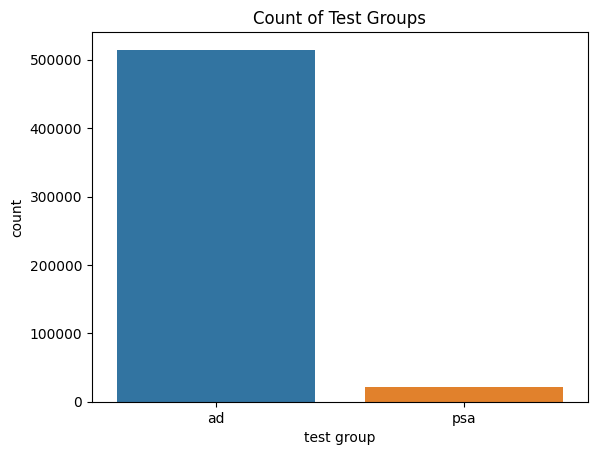

In [11]:
### making a new copy of the data
data = df_no_outliers.copy()

### Check the treatment column
sns.countplot(x="test group", data=data)
plt.title("Count of Test Groups")
plt.show()

<strong> we can see the the data treatment (ad) and control (psa) are have different size. This is somethign we have to address in the next step </strong>

In [12]:
# Group data by test group and converted status
pivot = data.groupby(['test group', 'converted']).size().unstack(fill_value=0)
pivot


converted,False,True
test group,,
ad,507827,6889
psa,21102,226


<strong> Number of adds between two groups </strong>

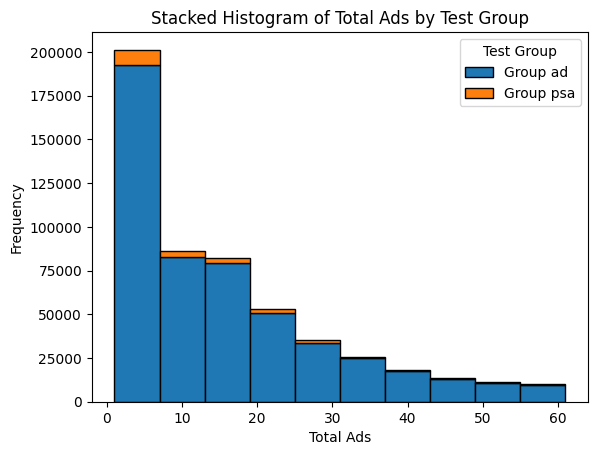

In [13]:
# Group by a categorical variable (e.g., 'test group')
categories = data['test group'].unique()  # Unique categories
bins = 10  # Number of bins

# Create a stacked histogram
plt.hist(
    [data[data['test group'] == category]['total ads'] for category in categories],
    bins=bins,
    label=[f"Group {category}" for category in categories],
    stacked=True,
    edgecolor="black"
)

# Add labels and legend
plt.title('Stacked Histogram of Total Ads by Test Group')
plt.xlabel('Total Ads')
plt.ylabel('Frequency')
plt.legend(title='Test Group')
plt.show()

<string> It aprears that control and treatment groups are similar in terms of exposing to number of ads. 

# Unbalanced data


Unbalanced data in A/B testing affects the analysis by introducing challenges in statistical accuracy and interpretation. When groups have unequal sizes, the smaller group may have higher variance, making it harder to detect true effects or differences. This can reduce the statistical power of the test, increasing the likelihood of false negatives (failing to detect a real effect). Additionally, standard statistical tests assume balanced or nearly balanced data, so adjustments (e.g., weighted averages or using statistical methods that account for imbalance) are often required to ensure valid results. Properly addressing these imbalances is essential to avoid biased conclusions and maintain the reliability of the analysis.


<strong> To solve this problem we calculate the number we need to sample from exsiting data based on siginificance level, desired power, and base and desired conversion rate </strong>

## Conversion Rate

In [14]:
# Calculate the current conversion rate
df_current =  data[data['test group']=="psa"]
conversion_rate = df_current[df_current['converted'] == 1].shape[0] / df_current.shape[0]
print(f"Current conversion rate: {conversion_rate:.2%}")


Current conversion rate: 1.06%


## Sample Size Calculation

In [15]:

# Parameters
alpha = 0.05  # significance level
power = 0.8   # power (1 - beta)
p1 = 0.01    # baseline conversion rate
p2 = 0.02   # test conversion rate

# Calculate effect size (Cohen's h)
effect_size = proportion_effectsize(p1, p2)

# Initialize power analysis
analysis = TTestIndPower()

# Calculate sample size per group
sample_size = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')

required_n = math.floor(sample_size)
print(required_n)

2254


# Sampling

In [16]:
control_sample = data[data['test group'] == "ad"].sample(n=required_n, random_state=34)
treatment_sample = data[data['test group'] == "psa"].sample(n=required_n, random_state=34)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4508 entries, 0 to 4507
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   test group     4508 non-null   object
 1   converted      4508 non-null   bool  
 2   total ads      4508 non-null   int64 
 3   most ads day   4508 non-null   object
 4   most ads hour  4508 non-null   int64 
dtypes: bool(1), int64(2), object(2)
memory usage: 145.4+ KB


In [17]:
ab_test['test group'].value_counts()

test group
ad     2254
psa    2254
Name: count, dtype: int64

In [18]:
conversion_rates = ab_test.groupby('test group')['converted']
conversion_rates
std_p = lambda x: np.std(x, ddof=0)   # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0) # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
test group,,,
ad,0.013,0.115,0.002
psa,0.010,0.098,0.002


## Hypothesis for Z-Test

**Null Hypothesis (H<sub>0</sub>):**  
There is no difference in the conversion rates between the control group (PSA) and the treatment group (ad).  


H0: p_control= p_treatment


**Alternative Hypothesis (H<sub>1</sub>):**  
There is a difference in the conversion rates between the control group (PSA) and the treatment group (ad).

H1: p_control != p_treatment


# Z-test for Proportion 
A Z-test for proportions is used in this scenario to compare the conversion rates (proportions) between two groups: the control group and the treatment group. The primary goal is to determine whether the difference in conversion rates is statistically significant or due to random chance.


In [19]:

control_results = ab_test[ab_test['test group'] == 'psa']['converted']
treatment_results = ab_test[ab_test['test group'] == 'ad']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()

successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')


z statistic: -1.12
p-value: 0.264
ci 95% for control group: [0.006, 0.014]
ci 95% for treatment group: [0.009, 0.018]


# Analysis of Results

<strong> P-Value:0.264 </strong>
This means there is insufficient evidence to reject the null hypothesis. In other words, the observed difference in conversion rates between the control and treatment groups is not statistically significant.

<strong> Confidence Intervals (CI):</strong>

For the control group, the 95% CI for the conversion rate is [0.006, 0.014].
For the treatment group, the 95% CI for the conversion rate is [0.009, 0.018].
These intervals overlap, further suggesting that the difference in conversion rates is not statistically significant

# Other Explorations | Logistic Regression


In the final step, logistic regression was employed to determine whether factors other than exposure to advertisements influence conversion. First, the categorical variable representing the day with the highest ad exposure was transformed into numerical columns using one-hot encoding. Logistic regression analysis was then conducted to identify which variables, if any, significantly predict the target variable, conversion.

In [20]:

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop=None)

# Fit and transform the 'most ads day' column
encoded_array = encoder.fit_transform(ab_test[['most ads day']])

# Convert the result into a DataFrame with appropriate columns
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['most ads day']))

# Reset the index for both the original and encoded DataFrames
ab_test.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

# Concatenate original DataFrame and encoded DataFrame
result = pd.concat([ab_test, encoded_df], axis=1)

# Drop the original 'most ads day' column and one dummy column to avoid multicollinearity
result.drop(["most ads day", "most ads day_Monday"], axis=1, inplace=True)

# Replace test group values
result["test group"] = result["test group"].replace(["psa", "ad"], [0, 1])

# Independent variables (X) and dependent variable (y)
X = result.drop(['converted'], axis=1)  # Do not use inplace=True here
y = result['converted']

# Display X and y
print(X.head())
print(y.head())


   test group  total ads  most ads hour  most ads day_Friday  \
0           1          1              9                  1.0   
1           1          3             20                  0.0   
2           1         18             16                  0.0   
3           1          2             16                  1.0   
4           1          8             17                  0.0   

   most ads day_Saturday  most ads day_Sunday  most ads day_Thursday  \
0                    0.0                  0.0                    0.0   
1                    0.0                  0.0                    0.0   
2                    0.0                  1.0                    0.0   
3                    0.0                  0.0                    0.0   
4                    0.0                  0.0                    1.0   

   most ads day_Tuesday  most ads day_Wednesday  
0                   0.0                     0.0  
1                   0.0                     0.0  
2                   0.0         

In [21]:
X = sm.add_constant(X)  # Adds a constant column to X
# Fit the logistic regression model
model = sm.Logit(y, X)
outcome = model.fit()
print(outcome.summary())

Optimization terminated successfully.
         Current function value: 0.059207
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:                 4508
Model:                          Logit   Df Residuals:                     4498
Method:                           MLE   Df Model:                            9
Date:                Fri, 27 Dec 2024   Pseudo R-squ.:                 0.05934
Time:                        23:28:43   Log-Likelihood:                -266.90
converged:                       True   LL-Null:                       -283.74
Covariance Type:            nonrobust   LLR p-value:                 0.0001019
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -5.4691      0.608     -8.998      0.000      -6.660      

# Final Conclusion

The results of the logistic regression indicate that only the total number of ads exposed is a significant factor influencing conversion, as all other variables have p-values greater than the significance level of 0.05. 
 in the end we conclude that the advertisement that was the treatment in this experiment was not successful in increasing the conversion rate.